In [ ]:
# %pip install pennylane
# %pip install PennyLane-qiskit

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import tensorflow as tf
import pennylane as qml
from pennylane import numpy as np

tf.get_logger().setLevel('ERROR')

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

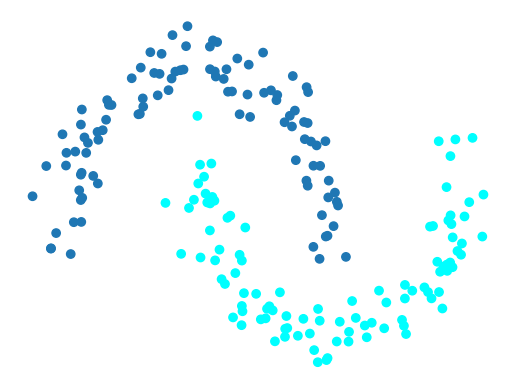

In [ ]:
X, y = make_moons(n_samples=200, noise=0.1)
y_hot = tf.keras.utils.to_categorical(y, num_classes=2)
c = ['#1f77b4' if y_ == 0 else '#00FFFF' for y_ in y]
plt.axis('off')
plt.scatter(X[:, 0], X[:, 1], c=c)
plt.show()

Cast the input data to float32

In [ ]:
X = X.astype('float32')
y_hot = y_hot.astype('float32')

Create quantum circuit

In [ ]:
token = 'Your IBM token'

In [ ]:
n_qubits = 2
# dev = qml.device("default.qubit", wires=n_qubits)
# dev = qml.device("qiskit.aer", wires=n_qubits)
dev = qml.device('qiskit.ibmq', wires=n_qubits, backend='ibm_nairobi', ibmqx_token=token)

In [ ]:
@qml.qnode(dev)
def qnode(inputs, weights):
    weights = np.array(weights, dtype=np.float32)
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

In [ ]:
n_layers = 3
weight_shapes = {"weights": (n_layers, n_qubits, 3)}

Create quantum layer

In [ ]:
qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)

Create quantum model

In [ ]:
model_q = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(2,)),
    qlayer,
    tf.keras.layers.Dense(2)  # Output layer
])

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.2)
model_q.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])

Compile the model for regression using a traditional (`adam`) optimizer

In [ ]:
q_history = model_q.fit(X, y_hot, epochs=6, batch_size=5, validation_split=0.25)

Epoch 1/6


/usr/local/lib/python3.10/dist-packages/pennylane/math/utils.py:225: UserWarning: Contains tensors of types {'autograd', 'tensorflow'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pennylane_qiskit/ibmq.py:91: UserWarning: ibmqx_token is not a recognized runtime option and may be ignored by the backend.
  res = super().batch_execute(circuits, timeout=self.timeout_secs)


30/30 [==============================] - 991s 27s/step - loss: 0.4066 - accuracy: 0.4467 - val_loss: 0.2212 - val_accuracy: 0.4600
Epoch 2/6
30/30 [==============================] - 597s 20s/step - loss: 0.2376 - accuracy: 0.6133 - val_loss: 0.3215 - val_accuracy: 0.5600
Epoch 3/6
30/30 [==============================] - 1689s 58s/step - loss: 0.2327 - accuracy: 0.6400 - val_loss: 0.1879 - val_accuracy: 0.8000
Epoch 4/6
30/30 [==============================] - 2097s 72s/step - loss: 0.2088 - accuracy: 0.6867 - val_loss: 0.3037 - val_accuracy: 0.6400
Epoch 5/6
30/30 [==============================] - 742s 25s/step - loss: 0.2538 - accuracy: 0.6400 - val_loss: 0.2114 - val_accuracy: 0.7800
Epoch 6/6
30/30 [==============================] - 1006s 34s/step - loss: 0.1814 - accuracy: 0.7600 - val_loss: 0.1710 - val_accuracy: 0.7200


In [ ]:
print(model_q.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2)                 18        
                                                                 
 dense (Dense)               (None, 2)                 6         
                                                                 
Total params: 24
Trainable params: 24
Non-trainable params: 0
_________________________________________________________________
None


Validation

In [ ]:
X_val, y_val = make_moons(n_samples=100, noise=0.1)
y_hot_pred = model_q.predict(X_val)
y_pred = tf.argmax(y_hot_pred, axis=1)

4/4 [==============================] - 138s 31s/step


In [ ]:
acc = tf.keras.metrics.Accuracy()
acc(y_pred, y_val)

<tf.Tensor: shape=(), dtype=float32, numpy=0.77>

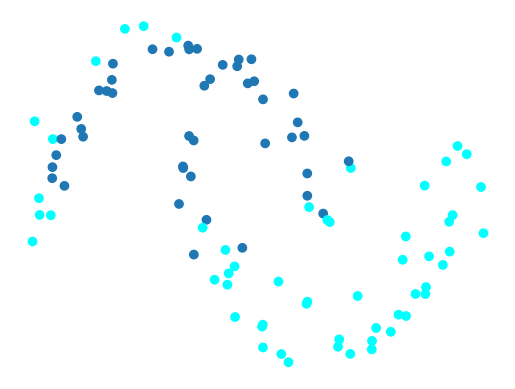

In [ ]:
c = ['#1f77b4' if y_ == 0 else '#00FFFF' for y_ in y_pred]
plt.axis('off')
plt.scatter(X_val[:, 0], X_val[:, 1], c=c)
plt.show()

Create classic model

In [ ]:
clayer_1 = tf.keras.layers.Dense(2)
clayer_2 = tf.keras.layers.Dense(2, activation='softmax')

In [ ]:
model_c = tf.keras.models.Sequential([clayer_1, clayer_2])

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.2)
model_c.compile(optimizer=optimizer, loss='mae', metrics=['accuracy'])

In [ ]:
c_history = model_c.fit(X, y, epochs=6, batch_size=5, validation_split=0.25)

Epoch 1/6
30/30 [==============================] - 1s 6ms/step - loss: 0.5000 - accuracy: 0.6400 - val_loss: 0.5000 - val_accuracy: 0.6800
Epoch 2/6
30/30 [==============================] - 0s 2ms/step - loss: 0.5000 - accuracy: 0.6467 - val_loss: 0.5000 - val_accuracy: 0.6800
Epoch 3/6
30/30 [==============================] - 0s 2ms/step - loss: 0.5000 - accuracy: 0.6467 - val_loss: 0.5000 - val_accuracy: 0.6800
Epoch 4/6
30/30 [==============================] - 0s 2ms/step - loss: 0.5000 - accuracy: 0.6600 - val_loss: 0.5000 - val_accuracy: 0.6600
Epoch 5/6
30/30 [==============================] - 0s 2ms/step - loss: 0.5000 - accuracy: 0.6533 - val_loss: 0.5000 - val_accuracy: 0.6600
Epoch 6/6
30/30 [==============================] - 0s 2ms/step - loss: 0.5000 - accuracy: 0.6533 - val_loss: 0.5000 - val_accuracy: 0.6800


In [ ]:
print(model_c.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (5, 2)                    6         
                                                                 
 dense_2 (Dense)             (5, 2)                    6         
                                                                 
Total params: 12
Trainable params: 12
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
X_val, y_val = make_moons(n_samples=100, noise=0.1)
y_hot_pred = model_c.predict(X_val)
y_pred = tf.argmax(y_hot_pred, axis=1)

4/4 [==============================] - 0s 3ms/step


In [ ]:
acc = tf.keras.metrics.Accuracy()
acc(y_pred, y_val)

<tf.Tensor: shape=(), dtype=float32, numpy=0.65>

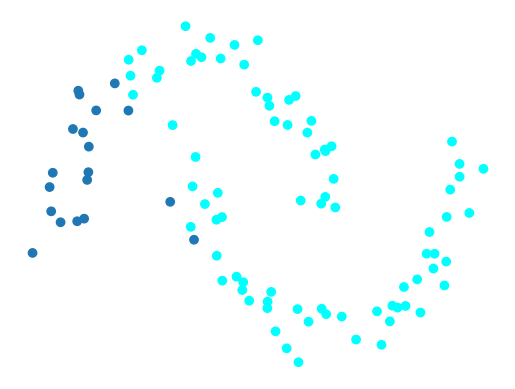

In [ ]:
c = ['#1f77b4' if y_ == 0 else '#00FFFF' for y_ in y_pred]
plt.axis('off')
plt.scatter(X_val[:, 0], X_val[:, 1], c=c)
plt.show()

Visualization

<ipython-input-31-ccd9aaf16753>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


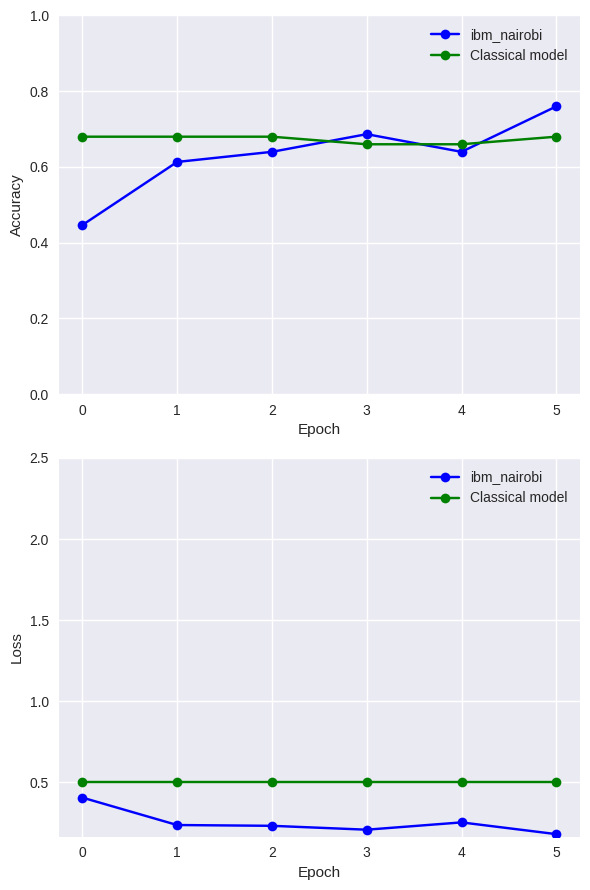

In [ ]:
plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["accuracy"], "-ob", label="ibm_nairobi")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Classical model")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["loss"], "-ob", label="ibm_nairobi")
ax2.plot(c_history.history["val_loss"], "-og", label="Classical model")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()

plt.tight_layout()
plt.show()